In [1]:
# An idea behind this experiment is to validate the concept of predicting house price by looking at raw data i.e. area, zipcode, # no of bathroom, #no of bedroom and images dataset  
# i.e. bathroom, bedroom, kitchen and frontal images of houses. By combining these two datasets, can we able to predict the house price effectively or not. Data and code credit to 
# URL: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ (Author: Adrian Rosebrock). This is the third experiment and if you are interested in the previous two experiments 
# then kindly visit the above URL.

# Through this experiment, we are going to deal with continuous, categorical and images dataset

# Train dataset ~(291 samples): 1) raw data from csv file and 2) image data (A single image in the train dataset represents bathroom, bedroom, kitchen and frontal images into a single image)
# Test dataset ~(94 samples):   1) raw data from csv file and 2) image data (A single image in the test dataset represents bathroom, bedroom, kitchen and frontal images into a single image) 

# Model 1: MLP is based on categorical and continuous data 
# Model 2: CNN is based on images data

# Especially thanks to Goole Colab for providing the GPU access. 

# Let's verify whether GPU access is enabled or not
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# Load data from Github
!git clone https://github.com/emanhamed/Houses-dataset
Username: 'Enter your GitHub user name'
Password: 'Paste here your GitHub access token'

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2161, done.
remote: Total 2161 (delta 0), reused 0 (delta 0), pack-reused 2161
Receiving objects: 100% (2161/2161), 176.26 MiB | 48.12 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [3]:
# Read data from csv file. Raw data has five columns:
import pandas as pd
col=["bedroom","bathroom","area","zipcode","price"]
df =pd.read_csv('/content/Houses-dataset/Houses Dataset/HousesInfo.txt',sep=" ",header=None,names=col)
df.head()

,bedroom,bathroom,area,zipcode,price
0,4,4.0,4053,85255,869500.0
1,4,3.0,3343,36372,865200.0
2,3,4.0,3923,85266,889000.0
3,5,5.0,4022,85262,910000.0
4,3,4.0,4116,85266,971226.0


In [0]:
# Remove rows where zipcode count < 25. In that case, we have very few samples and it is not helpful for the prediction:
zipcode= df.groupby('zipcode').size()
kep_col = zipcode[zipcode>25].keys().tolist()
len(df)

for i in range(len(df)):
  if kep_col.__contains__(df.loc[i,"zipcode"]):
     "True"
  else:
    df.drop(i,inplace=True)
  #print(df.loc[i,"zipcode"])

In [0]:
from sklearn.model_selection import train_test_split
df = df.sample(frac=1) # Random data shuffling
(train,test)=train_test_split(df, test_size=0.25, random_state=42) # Split training and test dataset

In [0]:
# One hot encoding on zipcode column
from sklearn.preprocessing import LabelBinarizer
zipBinarizer = LabelBinarizer().fit(df["zipcode"])
categorical_train_x = zipBinarizer.transform(train["zipcode"])
categorical_test_x = zipBinarizer.transform(test["zipcode"])

In [0]:
import numpy as np
# Min-max normalization on the target variable
train_y = train["price"] / (train["price"].max())
test_y = test["price"] / (train["price"].max())
# Extract continuous columns from train and test set
conti_train_x = train.iloc[:,0:3]
conti_test_x = test.iloc[:,0:3]
# Min-max normalization on continuous column both on train and test set
mean = conti_train_x.mean(axis=0)
std = conti_train_x.std(axis=0)
conti_train_x -= mean
conti_train_x /= std

conti_test_x -= mean
conti_test_x /= std

# Combine continuous and categorical columns form train and test set
train_raw_x = np.hstack([conti_train_x,categorical_train_x])
test_raw_x = np.hstack([conti_test_x,categorical_test_x])

In [139]:
# Following function reads images (i.e. bathroom, bedroom, kitchen and frontal images of house) from directory, form a single image by concating all four images.
import os, shutil
%pylab inline
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def load_img(df,path):
  images = []
  
  for i in df.index.values:
    bathroom = os.path.sep.join([path, "{}_bathroom.jpg".format(i + 1)])
    bedroom = os.path.sep.join([path, "{}_bedroom.jpg".format(i + 1)])
    kitchen = os.path.sep.join([path, "{}_kitchen.jpg".format(i + 1)])
    frontal = os.path.sep.join([path, "{}_frontal.jpg".format(i + 1)])
    inputImages=[]
    outputImage = np.zeros((128,128, 3), dtype="uint8")
    housepath=[bathroom,bedroom,kitchen,frontal]    
    for imgpath in range(1):
      br = cv2.resize(cv2.imread(housepath[0]), (64,64))
      inputImages.append(br)
      bedr = cv2.resize(cv2.imread(housepath[1]), (64,64))
      inputImages.append(bedr)
      ki = cv2.resize(cv2.imread(housepath[2]), (64, 64))
      inputImages.append(ki)
      fr = cv2.resize(cv2.imread(housepath[3]), (64, 64))
      inputImages.append(fr)
      # tile the four input images in the output image such the first
		  # image goes in the top-right corner, the second image in the
		  # top-left corner, the third image in the bottom-right corner,
		  # and the final image in the bottom-left corner
      outputImage[0:64, 0:64] = inputImages[0]
      outputImage[0:64, 64:128] = inputImages[1]
      outputImage[64:128, 64:128] = inputImages[2]
      outputImage[64:128, 0:64] = inputImages[3]
      images.append(outputImage)
      #from matplotlib import pyplot as plt
      #plt.imshow(outputImage)
      #plt.show()
  return np.array(images)

Populating the interactive namespace from numpy and matplotlib


In [0]:
# Load train and test images
train_img_x = load_img(train_y,'/content/Houses-dataset/Houses Dataset')
test_img_x = load_img(test_y,'/content/Houses-dataset/Houses Dataset')

In [0]:
# Normalize the training and testing images
train_img_x = train_img_x / 255.0
test_img_x = test_img_x / 255.0

In [11]:
# Print shape of train (raw data and images), test (raw data and images) set and corresponding label
print("Training raw features "+str(train_raw_x.shape))
print("Training images "+str(train_img_x.shape))
print("Training label "+str(train_y.shape))
print("Testing raw features "+str(test_raw_x.shape))
print("Testing images "+str(test_img_x.shape))
print("Testing label "+str(test_y.shape))

Training raw features (271, 10)
Training images (271, 128, 128, 3)
Training label (271,)
Testing raw features (91, 10)
Testing images (91, 128, 128, 3)
Testing label (91,)


In [0]:
from keras import models
from keras import layers
from keras.models import Model
from keras.layers import concatenate
from keras.layers.core import Dense

# Model 1: Create MLP: This model is based on raw data i.e. data from csv file.
model = models.Sequential()
model.add(layers.Dense(8, input_shape=(train_raw_x.shape[1],), activation="relu"))
model.add(layers.Dense(4, activation="relu"))

# Model 2: Create CNN based model: This model is based on bathroom, bedroom, kitchen and frontal images.
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(train_img_x.shape[1],train_img_x.shape[2], train_img_x.shape[3])))
model1.add(layers.MaxPooling2D(2, 2))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(2, 2))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(2, 2))
model1.add(layers.Dropout(0.5))
model1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D(2, 2))
model1.add(layers.Dropout(0.5))
model1.add(layers.Flatten())
model1.add(layers.Dense(4, activation='relu'))

# Combine both models
combine_model = concatenate([model.output, model1.output])
x = Dense(4,activation="relu")(combine_model)
x = Dense(1)(x)
hist = Model(inputs=[model.input, model1.input], outputs=x)

In [49]:
# Summary of the combined model
hist.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_41_input (InputLayer)    (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 126, 126, 32) 896         conv2d_41_input[0][0]            
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 63, 63, 32)   0           conv2d_41[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 61, 61, 64)   18496       max_pooling2d_32[0][0]           
__________________________________________________________________________________________________
max_poolin

In [0]:
# Generate the .png file for the above model
from keras.utils.vis_utils import plot_model
plot_model(hist, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

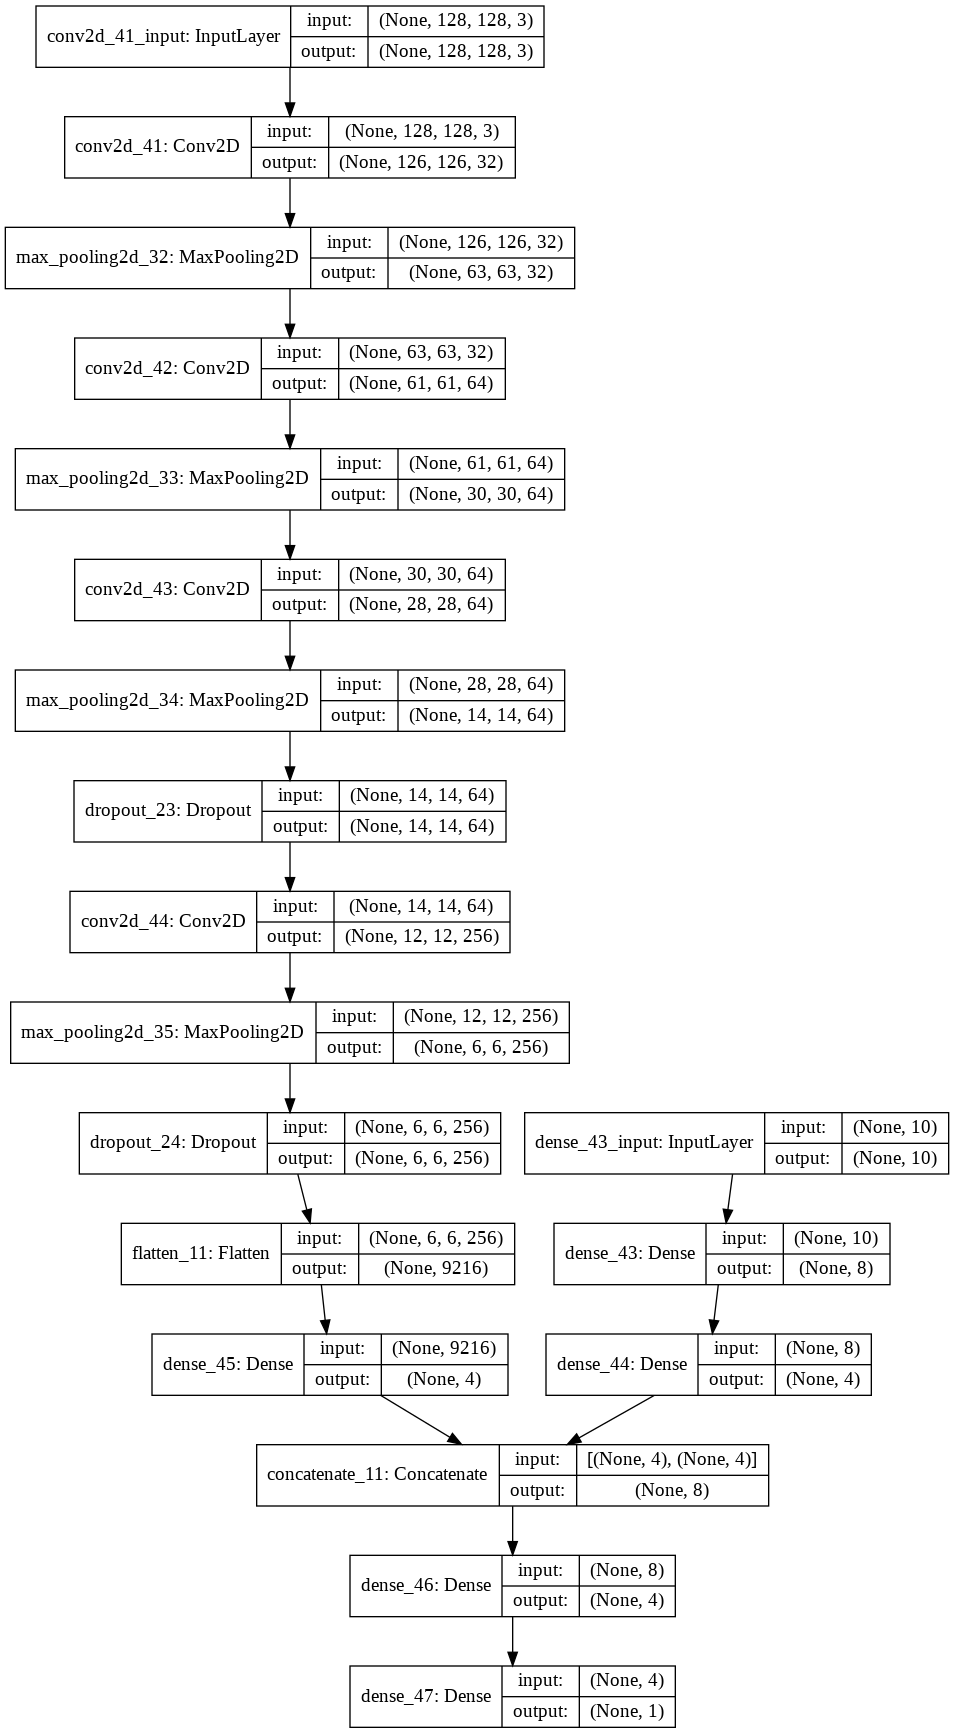

In [129]:
# Retrieve the model summary from the image generated using the above step
from IPython.display import Image
Image('/content/model_plot.png')

In [0]:
# Compile the combine model
from keras.optimizers import Adam
hist.compile(loss="mean_absolute_percentage_error",optimizer=Adam(lr=1e-3, decay=1e-3 / 200))

In [66]:
# Train the combine model: It needs multiple input i.e. 1) raw data from csv file for MLP model and 2) images for CNN model
hist.fit([train_raw_x,train_img_x], train_y,validation_data=([test_raw_x,test_img_x], test_y),epochs=300,batch_size=8)
# Here I have trained model multiple times so output might be different from the below one

Train on 271 samples, validate on 91 samples
Epoch 1/50
271/271 [==============================] - 2s 8ms/step - loss: 22.0241 - val_loss: 23.8874
Epoch 2/50
271/271 [==============================] - 0s 2ms/step - loss: 20.6308 - val_loss: 24.8890
Epoch 3/50
271/271 [==============================] - 0s 2ms/step - loss: 20.3472 - val_loss: 25.6021
Epoch 4/50
271/271 [==============================] - 0s 1ms/step - loss: 19.8320 - val_loss: 25.1191
Epoch 5/50
271/271 [==============================] - 0s 1ms/step - loss: 20.2347 - val_loss: 23.6054
Epoch 6/50
271/271 [==============================] - 0s 1ms/step - loss: 20.8320 - val_loss: 25.6363
Epoch 7/50
271/271 [==============================] - 0s 1ms/step - loss: 21.2761 - val_loss: 26.3720
Epoch 8/50
271/271 [==============================] - 0s 1ms/step - loss: 21.2322 - val_loss: 26.9586
Epoch 9/50
271/271 [==============================] - 0s 1ms/step - loss: 21.0815 - val_loss: 24.1919
Epoch 10/50
271/271 [================

In [0]:
# Make a prediction on the test data. We need raw data and image dataset to test our model.
preds = hist.predict([test_raw_x,test_img_x])

In [0]:
# Compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference

diff = preds.flatten() - np.vstack(test_y).flatten()
perdiff = (diff / np.vstack(test_y).flatten()) * 100
absdiff = np.abs(perdiff)

In [0]:
mean = np.mean(absdiff)
std = np.std(absdiff)

In [70]:
mean,std

(24.45502428781207, 21.402196449476328)

In [0]:
# Our final mean absolute percentage error implies, that on average, our network will be ~24.45% off in its house price predictions with a standard deviation of ~21.40%.
# This means if actual price is $695000.00 then predicted price may be $695000.00+695000.00*24% or $695000.00-695000.00*24%

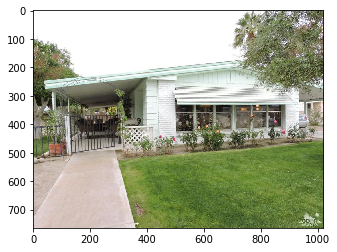

Actual price of this house is $ 99900.00 and predicted price of this house is $ 97494.38


In [123]:
i = 77 # Enter i from 0 to 91 i.e. index of test set. In test set, we have 91 samples. 
index = test_y.index.values[i]

frontal = os.path.sep.join(['/content/Houses-dataset/Houses Dataset', "{}_frontal.jpg".format(index)])
from matplotlib import pyplot as plt
img=mpimg.imread(frontal)
imgplot = plt.imshow(img)
plt.show()
print("Actual price of this house is $ {0:.2f}".format(test_y.iloc[i] *(train["price"].max()) )+ " and predicted price of this house is $ "+str(np.squeeze(preds[i] * (train["price"].max()))))